In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import copy
warnings.simplefilter("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']   #设置简黑字体
plt.rcParams['axes.unicode_minus'] = False # 解决‘-’bug

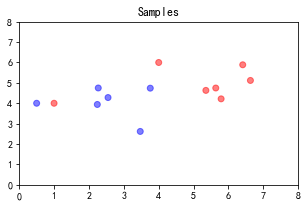

In [2]:
np.random.seed(4342)

x1 = np.random.rand(5, 2) * 3 + 2 
y1 = [0] * len(x1)

x2 = np.random.rand(5, 2) * 3 + 4
y2 = [1] * len(x2)

xt = np.array([
    [1, 4],
    [0.5, 4],
    [4, 6],
])
yt = np.array([1, 0, 1])

x = np.concatenate([x1, x2, xt], axis=0)
y = np.concatenate([y1, y2, yt])


plt.figure(figsize=(5, 3))
plt.title("Samples")
plt.scatter(x[:, 0], x[:, 1], c=y, cmap="bwr", alpha=0.5)
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.show()

In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_inv(f):
    return f * (1-f)


class Node(object):
    def __init__(self, name):
        self.name = name
        self.input = None
        self.output = None
        self.active = sigmoid
        self.loss = None
        self.delta = None
        self.active_inv = sigmoid_inv
        pass
    pass

class Net(object):
    def __init__(self, nodes):
        self.nodes = nodes
        self.weights = None
        self.bias = None
        self.fInitWeight()
        self.fInitBias()
        self.MSE = None
        self.label = None
        pass
    
    def fShowNet(self):
        for i, layer in enumerate(self.nodes):
            for node in layer:
                print(f"layer = {i} , node.name = {node.name}")
        pass
    
    def fShowNodes(self):
        for i, layer in enumerate(self.nodes):
            for node in layer:
                print(f"layer = {i} , node.name = {node.name} node.outout = \n{node.output}")
        pass
    
    def fInitWeight(self):
        np.random.seed(seed_weights)
        self.weights = list()
        for i in range(len(self.nodes) - 1):
            layer1 = self.nodes[i]
            layer2 = self.nodes[i+1]
            layer_weights = list()
            for node1 in layer1:
                node_weights = list()
                for node2 in layer2:
                    tmp_weight = np.random.rand()
                    node_weights.append(tmp_weight)
                layer_weights.append(node_weights)
            self.weights.append(np.array(layer_weights))
        pass
    
    def fInitBias(self):
        np.random.seed(seed_bias)
        self.bias = list()
        for i in range(len(self.nodes)-1):
            self.bias.append(np.random.randn())
        pass
    
    def fForwardPropagate(self, x):
        layer = self.nodes[0]
        for i, node in enumerate(layer):
            node.input = x[:, i]
            node.output = node.input
        
        for i in range(len(self.nodes)-1):
            layer1 = self.nodes[i]
            layer2 = self.nodes[i+1]
            tmp_weight = self.weights[i]
            tmp_bias = self.bias[i]
            
            for k2 in range(len(layer2)):
                tmp_node2 = layer2[k2]
                tmp_w = tmp_weight[:, k2]
                tmp_x = list()
                for k1 in range(len(layer1)):
                    tmp_node1 = layer1[k1]
                    tmp_output = tmp_node1.output
                    tmp_x.append(tmp_output)
                tmp_x = np.array(tmp_x).T
                tmp_input2 = tmp_x @ tmp_w + tmp_bias
                tmp_node2.input = tmp_input2
                tmp_node2.output = layer2[k2].active(tmp_input2)      
        pass

    def fBackPropagate(self, y):  
        layer = self.nodes[-1]
        for i in range(len(layer)):
            node = layer[i]
            node.loss = - (y[:, i] - node.output)
            node.delta = node.loss * node.active_inv(node.output)    
            # print(node.name, node.loss, node.delta)
        
        for i in range(len(self.nodes)-1, 0 , -1):
            layer1 = self.nodes[i]
            layer2 = self.nodes[i-1]
            for k2 in range(len(layer2)):
                tmp_delta = 0
                for k1 in range(len(layer1)):
                    node1 = layer1[k1]
                    node2 = layer2[k2]
                    tmp_delta += node1.delta * node2.active_inv(node2.output)
                node2.delta = tmp_delta
        pass
    
    
    def fForwardUpdateWeight(self):
        for i in range(len(self.nodes)-1):
            layer1 = self.nodes[i]
            layer2 = self.nodes[i+1]
            for k1 in range(len(layer1)):
                for k2 in range(len(layer2)):
                    node1 = layer1[k1]
                    node2 = layer2[k2]
                    tmp_weight = self.weights[i][k1][k2]
                    tmp_delta = node2.delta
                    tmp_x = node1.output
                    tmp_update = np.mean(tmp_delta * tmp_x)
                    # print(i, k1, k2, tmp_update)
                    self.weights[i][k1][k2] = tmp_weight - tmp_update
        pass
    
    def fForwardUpdateBias(self):
        for i in range(len(self.nodes)-1):
            layer2 = self.nodes[i+1]
            tmp_bias = self.bias[i]
            tmp_bias_item = 0
            for k2 in range(len(layer2)):
                node2 = layer2[k2]
                tmp_delta = node2.delta
                tmp_bias_item += np.mean(tmp_delta)
                # print(i, tmp_update)
            self.bias[i] = tmp_bias - tmp_bias_item
        pass
    
    def fGetMSE(self, y):
        output = self.nodes[-1][-1].output
        self.MSE = np.mean((output - y)**2)
        pass
    
    def run(self, loops=100):
        for loop in range(loops):
            self.fForwardPropagate(x)
            self.fBackPropagate(y.reshape(-1, 1))
            self.fForwardUpdateWeight()
            self.fForwardUpdateBias()
            self.fGetMSE(y)
            if loop%10000 == 0 :
                print(f"loop = {loop}, mse = {self.MSE}")
        tmp_label = np.array(self.nodes[-1][-1].output)
        tmp_label = np.where(tmp_label>=0.5, 1, 0)
        self.label = tmp_label
    pass


# 创建神经网络节点
nodes = [
    [Node("x1"), Node("x2"),],
    [Node("h1"), Node("h2"), Node("h3"), Node("h4"), Node("h5"),],
    [Node("y"),],
]

# 构建神经网络
seed_weights = 44145
seed_bias = 678990
nnet = Net(nodes)

nnet.run(1)
# print(nnet.nodes[-1][-1].output)
# print(nnet.bias)
# print(nnet.MSE)
# print("")

nnet.run(10000 * 10)
# print(nnet.nodes[-1][-1].output)
# print(nnet.bias)
# print(nnet.MSE)
# print("")
# print(nnet.label)

loop = 0, mse = 0.34586128679863903
loop = 0, mse = 0.32653836329172786
loop = 10000, mse = 0.051121250536086134
loop = 20000, mse = 0.04448729756744223
loop = 30000, mse = 0.03883382591811324
loop = 40000, mse = 0.008859797257126224
loop = 50000, mse = 0.0025134200570161207
loop = 60000, mse = 0.0013846146670885792
loop = 70000, mse = 0.0009352520208087538
loop = 80000, mse = 0.000698568804365612
loop = 90000, mse = 0.0005540005633815953


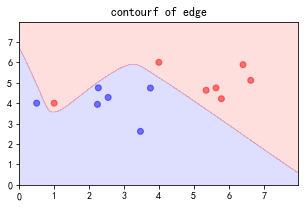

In [4]:
idx = np.arange(-0, 8, 0.01)
idy = np.arange(-0, 8, 0.01)

idxx, idyy = np.meshgrid(idx, idy)
idt = np.c_[idxx.ravel(), idyy.ravel()]

nnet.fForwardPropagate(idt)
idz = nnet.nodes[-1][-1].output

idz2 = idz.copy()
idz2[idz >= 0.5] = 1
idz2[idz < 0.5] = 0
# print(idz2)

idzz = idz2.reshape(idxx.shape)
# print(idzz)

plt.figure(figsize=(5, 3))
plt.title("contourf of edge")
plt.contourf(idxx, idyy, idzz, alpha=0.15, cmap="bwr")
plt.scatter(x[:, 0].ravel(), x[:, 1].ravel(), c=y, alpha=0.5, cmap="bwr")
plt.show()